In [21]:
import pandas as pd 
import numpy as np 
import keras 
import tarfile
import os
import lzma
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from sklearn.model_selection import StratifiedKFold, train_test_split
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from keras.backend import clear_session
from sklearn.metrics import f1_score
from scipy import stats
import keras_tuner as kt
from keras.layers import GRU, SimpleRNN, Dense, Dropout, Embedding
from sklearn.model_selection import StratifiedKFold, train_test_split


In [22]:
filepath = "data/cath.tar.xz"
output_dir = "data/extracted_data/cath"
os.makedirs(output_dir, exist_ok=True)

In [23]:
with lzma.open(filepath) as xz_file:
    with tarfile.open(fileobj=xz_file) as tar:
        tar.extractall(path=output_dir)

In [24]:
FN_DOMAIN_LIST = 'data/extracted_data/cath/proteins/domain_classification.txt'
FN_SF_NAMES = 'data/extracted_data/cath/proteins/superfamily_names.txt'
FN_SEQ_S60 = 'data/extracted_data/cath/proteins/seqs_S60.fa'


In [25]:
sequences = []
current_id = None
current_seq = []


with open(FN_SEQ_S60, 'r') as f:
    for line in f:
        line = line.strip()
        if line.startswith('>'):
            if current_id:
                sequences.append({
                    'domain_id': current_id, 
                    'sequence': "".join(current_seq)
                })
        
            parts = line[1:].split('|')
            
            if len(parts) >= 3:
                full_code = parts[2]
                current_id = full_code.split('/')[0]
            else:
                current_id = line[1:].split()[0]

            current_seq = []
        else:
            current_seq.append(line)
    
    # Save last entry
    if current_id:
        sequences.append({'domain_id': current_id, 'sequence': "".join(current_seq)})
            
df_seq =  pd.DataFrame(sequences)
df_seq.head()

,domain_id,sequence
0,12asA00,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
1,139lA00,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
2,16pkA01,EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKV...
3,16pkA02,YFAKVLGNPPRPLVAIVGGAKVSDKIQLLDNMLQRIDYLLIGGAMA...
4,16vpA00,SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...


In [26]:
col_names = ['domain_id', 'C', 'A', 'T', 'H', 'S', 'O', 'L', 'I', 'D', 'len', 'res']

df_domains = pd.read_csv(
    FN_DOMAIN_LIST, 
    sep=r'\s+', 
    comment='#', 
    header=None,
    names=col_names,
    usecols=['domain_id', 'C', 'A', 'T', 'H','S', 'O', 'L', 'I', 'D', 'len', 'res']
)

# Create Superfamily ID (C.A.T.H)
df_domains['superfamily_id'] = df_domains.apply(
    lambda x: f"{x['C']}.{x['A']}.{x['T']}.{x['H']}", axis=1
)

df_domains.head()


,domain_id,C,A,T,H,S,O,L,I,D,len,res,superfamily_id
0,1oaiA00,1,10,8,10,1,1,1,1,1,59,1.0,1.10.8.10
1,1go5A00,1,10,8,10,1,1,1,1,2,69,999.0,1.10.8.10
2,3frhA01,1,10,8,10,2,1,1,1,1,58,1.2,1.10.8.10
3,3friA01,1,10,8,10,2,1,1,1,2,54,1.8,1.10.8.10
4,3b89A01,1,10,8,10,2,1,1,2,1,54,2.6,1.10.8.10


In [27]:
print("Loading superfamily names...")
sf_names = {}
with open(FN_SF_NAMES, 'r') as f:
    for line in f:
        if line.startswith('#'): continue
        parts = line.strip().split(maxsplit=1)
        if len(parts) == 2:
            sf_names[parts[0]] = parts[1]

# D. Merge and Filter
print("Merging data and filtering...")
# Join sequences with classification
df_merged= pd.merge(df_seq, df_domains, on='domain_id', how='inner')
df_merged.head()


Loading superfamily names...
Merging data and filtering...


,domain_id,sequence,C,A,T,H,S,O,L,I,D,len,res,superfamily_id
0,12asA00,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,3,30,930,10,29,2,1,1,1,327,2.2,3.30.930.10
1,139lA00,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,1,10,530,40,4,1,1,1,1,162,1.7,1.10.530.40
2,16pkA01,EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKV...,3,40,50,1260,1,1,1,1,1,188,1.6,3.40.50.1260
3,16pkA02,YFAKVLGNPPRPLVAIVGGAKVSDKIQLLDNMLQRIDYLLIGGAMA...,3,40,50,1260,2,4,1,1,1,208,1.6,3.40.50.1260
4,16vpA00,SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...,1,10,1290,10,1,1,1,1,1,311,2.1,1.10.1290.10


In [33]:
sf_counts = df_merged['superfamily_id'].value_counts()
small_sfs = sf_counts[sf_counts < 1000]
top_5_sfs = small_sfs.nlargest(5).index.tolist()
df_filtered = df_merged[df_merged['superfamily_id'].isin(top_5_sfs)].copy()

print(f"Selected Superfamilies: {top_5_sfs}")
print(f"Number of domains selected: {len(df_filtered)}")

Selected Superfamilies: ['3.40.50.300', '1.10.10.10', '3.40.190.10', '3.40.30.10', '3.40.50.2300']
Number of domains selected: 3177


In [29]:
df_merged.shape[0]

45835

Encoder (1D-CNN): We will use a 1D Convolutional Neural Network.

Why?

Proteins have local motifs (short patterns of amino acids) that determine function. A 1D-CNN slides a "filter" over the sequence to detect these patterns, regardless of where they appear in the chain. It is computationally faster than RNNs (LSTMs) and works very well for this dataset size.

In [35]:
final_data = df_merged[df_merged['superfamily_id'].isin(top_5_sfs)].astype(str).copy()
final_data = final_data[["sequence", "superfamily_id"]].reset_index(drop=True)

In [36]:
list_seq = (final_data.sequence)
chars = []
for i in list_seq:
    for c in i:
        if c not in chars:
            chars.append(c)
len(chars)

21

In [37]:
max_len = int(final_data.sequence.str.len().max())

In [ ]:
#vectorization and padding 
vectorizer = keras.layers.TextVectorization(split="character", output_sequence_length=max_len)
vectorizer.adapt(final_data.sequence)
x = vectorizer(final_data.sequence)


<tf.Tensor: shape=(3177, 420), dtype=int64, numpy=
array([[10, 14, 15, ...,  0,  0,  0],
       [ 4,  2, 10, ...,  0,  0,  0],
       [19, 10,  7, ...,  0,  0,  0],
       ...,
       [ 6, 10, 19, ...,  0,  0,  0],
       [ 5, 14,  2, ...,  0,  0,  0],
       [ 3,  3, 11, ...,  0,  0,  0]], shape=(3177, 420))>

In [43]:
le = LabelEncoder()
y = le.fit_transform(final_data.superfamily_id)
num_classes = len(le.classes_)
y

array([3, 0, 3, ..., 4, 3, 3], shape=(3177,))

In [40]:
rng = np.random.RandomState(42)

x_numpy = x.numpy() if hasattr(x, 'numpy') else np.array(x)
y_numpy = y.numpy() if hasattr(y, 'numpy') else np.array(y)
y_numpy = y_numpy.astype(int)

TOKENS = 24
CLASSES = 5
DIMENSIONS = 16
UNITS = 128
SIZE = 4
DROPOUT_RATE = 0.5
LEEARNING_RATE = 0.001

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras_tuner as kt
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.backend import clear_session
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from scipy import stats

# --- CONFIGURATION ---
NUM_OUTER_FOLDS = 5
MAX_TRIALS = 5  
EPOCHS = 50
BATCH_SIZE = 32

# TOGGLE EARLY STOPPING HERE ('yes' or 'no')
USE_EARLY_STOPPING = 'yes' 

# --- HELPER FUNCTION FOR CONFIDENCE INTERVALS ---
def compute_95_ci(data):
    """Calculates Mean and 95% Confidence Interval margin."""
    data = np.array(data)
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + 0.95) / 2., n-1)
    return mean, h

def build_cnn(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(max_len,)))
    model.add(Embedding(TOKENS, DIMENSIONS, mask_zero=False))

    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(Conv1D(filters=hp_units, kernel_size=SIZE, activation="relu", padding='same'))
    model.add(MaxPooling1D(pool_size=SIZE))
    
    model.add(Flatten())
    model.add(Dense(hp_units, activation="relu"))
    
    hp_dropout = hp.Choice('dropout', values=[0.2, 0.5])
    model.add(Dropout(hp_dropout))

    model.add(Dense(CLASSES, activation="softmax"))

    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# --- STORAGE FOR RESULTS ---
outer_acc = []
outer_f1 = []
outer_loss = []
history_list = []

fold_no = 1
skf = StratifiedKFold(n_splits=NUM_OUTER_FOLDS, shuffle=True, random_state=42)

print(f"Starting {NUM_OUTER_FOLDS}-Fold Nested Cross-Validation...")
print(f"Early Stopping Enabled: {USE_EARLY_STOPPING}")

# --- OUTER LOOP ---
for train_index, test_index in skf.split(x_numpy, y_numpy):
    print(f"\n--- Processing Outer Fold {fold_no}/{NUM_OUTER_FOLDS} ---")
    
    x_outer_train, x_outer_test = x_numpy[train_index], x_numpy[test_index]
    y_outer_train, y_outer_test = y_numpy[train_index], y_numpy[test_index]
    
    # Inner Split (for Tuner)
    x_inner_train, x_inner_val, y_inner_train, y_inner_val = train_test_split(
        x_outer_train, y_outer_train, test_size=0.2, stratify=y_outer_train, random_state=42
    )

    tuner = kt.RandomSearch(
        build_cnn,
        objective='val_accuracy',
        max_trials=MAX_TRIALS,
        executions_per_trial=1,
        directory='nested_cv_results',
        project_name=f'tuning_fold_{fold_no}', 
        overwrite=True
    )

    # Search (Inner Loop)
    tuner.search(
        x_inner_train, y_inner_train,
        epochs=EPOCHS,
        validation_data=(x_inner_val, y_inner_val),
        # You can keep early stopping in the tuner to speed up search, 
        # regardless of the outer loop setting.
        callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0 
    )
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)

    # --- CONDITIONAL EARLY STOPPING LOGIC ---
    final_callbacks = [] # Default is empty list
    
    if USE_EARLY_STOPPING.lower() == 'yes':
        print(" > Early Stopping Active for this fold.")
        final_callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',  # Recommended: monitor accuracy to keep scores high
                patience=12,             # Generous patience
                restore_best_weights=True
            )
        ]
    
    # Refit Best Model
    history = best_model.fit(
        x_outer_train, y_outer_train,
        validation_data=(x_outer_test, y_outer_test), 
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=final_callbacks # Pass the conditional list here
    )
    
    history_list.append(history.history)

    # Evaluation
    eval_results = best_model.evaluate(x_outer_test, y_outer_test, verbose=0)
    fold_loss = eval_results[0]
    fold_acc = eval_results[1]
    
    y_pred_probs = best_model.predict(x_outer_test, verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    fold_f1 = f1_score(y_outer_test, y_pred_classes, average='macro')
    
    print(f"  > Fold {fold_no} Results -> Loss: {fold_loss:.4f} | Acc: {fold_acc:.4f} | F1: {fold_f1:.4f}")
    
    outer_loss.append(fold_loss)
    outer_acc.append(fold_acc)
    outer_f1.append(fold_f1)
    
    clear_session()
    fold_no += 1

# --- FINAL STATISTICS ---
mean_acc, ci_acc = compute_95_ci(outer_acc)
mean_f1, ci_f1 = compute_95_ci(outer_f1)
mean_loss, ci_loss = compute_95_ci(outer_loss)

print("\n============================================================")
print("FINAL NESTED CV RESULTS")
print("============================================================")
print(f"Accuracy:  {mean_acc:.4f}  (+/- {ci_acc:.4f})")
print(f"Macro F1:  {mean_f1:.4f}  (+/- {ci_f1:.4f})")
print(f"Loss:      {mean_loss:.4f}  (+/- {ci_loss:.4f})")
print("============================================================")
print(f"Report format: {mean_f1*100:.2f}% ± {ci_f1*100:.2f}% (95% CI)")
print("============================================================")

Starting 5-Fold Nested Cross-Validation...
Early Stopping Enabled: yes

--- Processing Outer Fold 1/5 ---



KeyboardInterrupt: 

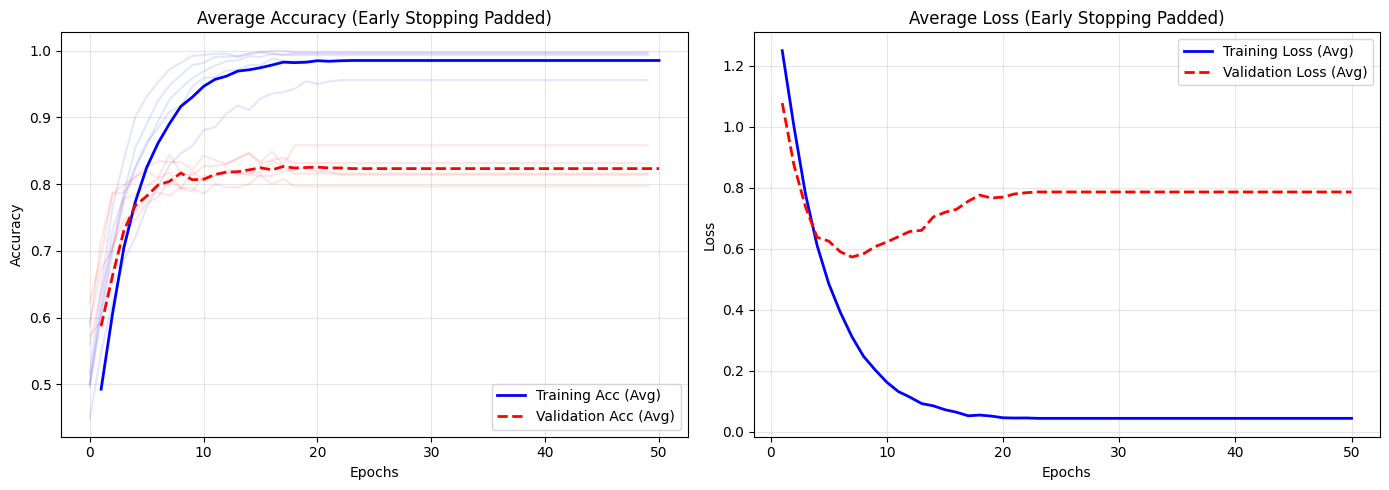

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_early_stopping_history(history_list, max_epochs=50):
    # Prepare arrays to hold padded data
    # Shape: (Num Folds, Max Epochs)
    acc_matrix = np.full((len(history_list), max_epochs), np.nan)
    val_acc_matrix = np.full((len(history_list), max_epochs), np.nan)
    loss_matrix = np.full((len(history_list), max_epochs), np.nan)
    val_loss_matrix = np.full((len(history_list), max_epochs), np.nan)

    for i, h in enumerate(history_list):
        num_epochs = len(h['accuracy'])
        
        # 1. Fill the actual data
        acc_matrix[i, :num_epochs] = h['accuracy']
        val_acc_matrix[i, :num_epochs] = h['val_accuracy']
        loss_matrix[i, :num_epochs] = h['loss']
        val_loss_matrix[i, :num_epochs] = h['val_loss']
        
        # 2. Pad the rest with the FINAL value (Horizontal Line effect)
        # This represents "if we kept the model frozen, how would it look?"
        acc_matrix[i, num_epochs:] = h['accuracy'][-1]
        val_acc_matrix[i, num_epochs:] = h['val_accuracy'][-1]
        loss_matrix[i, num_epochs:] = h['loss'][-1]
        val_loss_matrix[i, num_epochs:] = h['val_loss'][-1]

    # Calculate Mean across folds
    mean_acc = np.nanmean(acc_matrix, axis=0)
    mean_val_acc = np.nanmean(val_acc_matrix, axis=0)
    mean_loss = np.nanmean(loss_matrix, axis=0)
    mean_val_loss = np.nanmean(val_loss_matrix, axis=0)

    epochs_range = range(1, max_epochs + 1)

    # --- PLOTTING ---
    plt.figure(figsize=(14, 5))

    # ACCURACY
    plt.subplot(1, 2, 1)
    # Plot individual folds faintly to show variance
    for i in range(len(history_list)):
        plt.plot(acc_matrix[i], color='blue', alpha=0.1)
        plt.plot(val_acc_matrix[i], color='red', alpha=0.1)
        
    plt.plot(epochs_range, mean_acc, 'b-', linewidth=2, label='Training Acc (Avg)')
    plt.plot(epochs_range, mean_val_acc, 'r--', linewidth=2, label='Validation Acc (Avg)')
    plt.title('Average Accuracy (Early Stopping Padded)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # LOSS
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, mean_loss, 'b-', linewidth=2, label='Training Loss (Avg)')
    plt.plot(epochs_range, mean_val_loss, 'r--', linewidth=2, label='Validation Loss (Avg)')
    plt.title('Average Loss (Early Stopping Padded)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run it
plot_early_stopping_history(history_list, max_epochs=EPOCHS)

In [ ]:
def plot_cv_history(history_list):
    # 1. Aggregate data across folds
    # We assume all folds ran for the same number of epochs (EPOCHS)
    # If early stopping was used in the outer loop, we would need to pad arrays.
    
    train_acc = np.mean([h['accuracy'] for h in history_list], axis=0)
    val_acc   = np.mean([h['val_accuracy'] for h in history_list], axis=0)
    train_loss = np.mean([h['loss'] for h in history_list], axis=0)
    val_loss  = np.mean([h['val_loss'] for h in history_list], axis=0)
    
    epochs = range(1, len(train_acc) + 1)

    # 2. Create Plot
    plt.figure(figsize=(14, 5))

    # --- Accuracy Subplot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='Training Acc (Avg)')
    plt.plot(epochs, val_acc, 'r--', label='Validation/Test Acc (Avg)')
    plt.title('Average Accuracy over 5 Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- Loss Subplot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss (Avg)')
    plt.plot(epochs, val_loss, 'r--', label='Validation/Test Loss (Avg)')
    plt.title('Average Loss over 5 Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the plotter
plot_cv_history(history_list)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [ ]:
import keras_tuner as kt
from tensorflow import keras
from keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
# --- 1. DEFINE MODEL WITH HYPERPARAMETERS ---
def build_model(hp):
    # Tunable parameters
    # hp.Int defines a range of integers to try
    # hp.Choice defines specific options
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    dropout = hp.Choice('dropout', values=[0.2, 0.5])
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    model = keras.Sequential([
        keras.Input(shape=(max_len,)),
        Embedding(TOKENS, DIMENSIONS, mask_zero=True),
        
        Bidirectional(LSTM(units)),
        
        Dense(units, activation="relu"),
        Dropout(dropout),
        
        Dense(CLASSES, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# --- 2. SETUP THE TUNER ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # How many different model configurations to try
    executions_per_trial=1,
    directory='my_dir',
    project_name='cath_tuning'
)

# --- 3. RUN SEARCH (NO RECOMBINING!) ---
# Notice we pass validation_data explicitly here
print("Starting Keras Tuner Search...")

tuner.search(
    x_train, y_train,             # Your separated training data
    epochs=15,
    validation_data=(x_val, y_val), # Your separated validation data
    batch_size=32,
    verbose=1
)

# --- 4. GET BEST MODEL ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
Best units: {best_hps.get('units')}
Best learning rate: {best_hps.get('learning_rate')}
Best dropout: {best_hps.get('dropout')}
""")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report
from tensorflow import keras
from keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from keras.optimizers import Adam

# --- CONFIGURATION ---
UNITS = 64
LEARNING_RATE = 0.01  
DROPOUT_RATE = 0.5
EPOCHS = 50     
BATCH_SIZE = 32
FOLDS = 5

# NOTE: variables 'x', 'y', 'max_len', 'TOKENS', 'DIMENSIONS', 'CLASSES' 
# are assumed to be defined in your previous data loading step.

def build_lstm():
    model = keras.Sequential([
        keras.Input(shape=(max_len,)),
        # mask_zero=True is CRITICAL for speed/accuracy with padded sequences
        Embedding(TOKENS, DIMENSIONS, mask_zero=True),

        Bidirectional(LSTM(UNITS, return_sequences=True)),
        Bidirectional(LSTM(UNITS // 2)),

        Dense(UNITS, activation="relu"),
        Dropout(DROPOUT_RATE),

        Dense(CLASSES, activation="softmax")
    ])

    # MODIFICATION: Explicitly setting the Learning Rate
    opt = Adam(learning_rate=LEARNING_RATE)
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

# --- 1. CREATE HOLDOUT SET (Isolated until the very end) ---
# We reserve 10% of data strictly for the final evaluation.
# The other 90% (x_main) will be used for Cross-Validation.
x_main, x_holdout, y_main, y_holdout = train_test_split(
    x, y, test_size=0.1, stratify=y, random_state=42
)

print(f"Total Samples: {len(x)}")
print(f"Main set (for CV): {len(x_main)} | Holdout set (Final Test): {len(x_holdout)}")

# --- 2. 5-FOLD CROSS-VALIDATION ---
# We assess model stability using the Main set
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

cv_accuracies = []
cv_f1_scores = []

print(f"\n--- Starting {FOLDS}-Fold Cross-Validation ---")

fold_no = 1
for train_index, val_index in kfold.split(x_main, y_main):
    # Split data for this fold
    x_train_fold, x_val_fold = x_main[train_index], x_main[val_index]
    y_train_fold, y_val_fold = y_main[train_index], y_main[val_index]

    # Build and Train Model
    model = build_lstm()
    print(f"\nTraining Fold {fold_no}...")
    
    # Using EarlyStopping to save time if model converges
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    model.fit(
        x_train_fold, y_train_fold,
        validation_data=(x_val_fold, y_val_fold),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0, # Silent training for cleaner logs
        callbacks=[callback]
    )

    # Evaluate Fold
    y_pred_probs = model.predict(x_val_fold, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate Metrics
    acc = accuracy_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred, average='macro')
    
    cv_accuracies.append(acc)
    cv_f1_scores.append(f1)
    
    print(f"Fold {fold_no} Results -> Accuracy: {acc*100:.2f}%, Macro F1: {f1:.4f}")
    fold_no += 1

# --- 3. CV SUMMARY ---
print("-" * 30)
print(f"Average CV Accuracy: {np.mean(cv_accuracies)*100:.2f}% (+/- {np.std(cv_accuracies)*100:.2f}%)")
print(f"Average CV Macro F1: {np.mean(cv_f1_scores):.4f}")
print("-" * 30)

# --- 4. FINAL TRAINING & HOLDOUT EVALUATION ---
print("\n--- Retraining on Full Main Set & Evaluating on Holdout ---")

# Train on ALL of x_main (train + val from CV combined) to maximize learning
final_model = build_lstm()
final_model.fit(
    x_main, y_main,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict on the Holdout Set (Never seen before)
holdout_probs = final_model.predict(x_holdout, verbose=0)
holdout_preds = np.argmax(holdout_probs, axis=1)

# Metrics
final_acc = accuracy_score(y_holdout, holdout_preds)
final_f1 = f1_score(y_holdout, holdout_preds, average='macro')

# --- 5. CALCULATE 95% CONFIDENCE INTERVAL (For Accuracy) ---
# Formula: p +/- 1.96 * sqrt( (p * (1 - p)) / n )
n = len(y_holdout)
z_score = 1.96 # For 95% confidence
std_error = math.sqrt((final_acc * (1 - final_acc)) / n)
margin_of_error = z_score * std_error

lower_bound = (final_acc - margin_of_error) * 100
upper_bound = (final_acc + margin_of_error) * 100

print(f"\n=== FINAL HOLDOUT RESULTS ===")
print(f"Accuracy:  {final_acc*100:.2f}%")
print(f"95% CI:    [{lower_bound:.2f}%, {upper_bound:.2f}%]")
print(f"Macro F1:  {final_f1:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_holdout, holdout_preds))

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([2022, 2754, 1569, ..., 1834, 1519, 1118], shape=(2859,))

In [ ]:
# #LSTM with 5fold cv, fill this with the best hyperparams found from the grid search 
# from keras.layers import LSTM, Bidirectional
# #LONG TIME! 
# def build_lstm():
#     model = keras.Sequential([
#         keras.Input(shape=(max_len,)),
#         Embedding(TOKENS, DIMENSIONS, mask_zero=True),

#         Bidirectional(LSTM(UNITS, return_sequences=True)),
#         Bidirectional(LSTM(UNITS // 2)),

#         Dense(UNITS, activation="relu"),
#         Dropout(DROPOUT_RATE),

#         Dense(CLASSES, activation="softmax")
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
#     return model

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# fold_no = 1
# acc_per_fold = []
# loss_per_fold = []

# print(f"Starting {5}-Fold Stratified Cross-Validation...\n")

# x = np.array(x)
# y = np.array(y)


# for train_index, val_index in skf.split(x, y):

#     x_train_fold, x_val_fold = x[train_index], x[val_index]
#     y_train_fold, y_val_fold = y[train_index], y[val_index]
    
#     model = build_lstm()
    
#     print(f"------------------------------------------------------------------------")
#     print(f"Training for Fold {fold_no} ...")
    

#     history = model.fit(
#         x_train_fold, y_train_fold,
#         epochs=25,
#         batch_size=32,
#         verbose=0 
#     )
    
#     scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
#     print(f"Score for Fold {fold_no}: Loss of {scores[0]:.4f}; Accuracy of {scores[1]*100:.2f}%")
    
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])
    
#     fold_no += 1

# # --- 4. FINAL RESULTS ---

# print("\n------------------------------------------------------------------------")
# print("Average Scores for all folds:")
# print(f"> Accuracy: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)")
# print(f"> Loss: {np.mean(loss_per_fold):.4f}")
# print("------------------------------------------------------------------------")

Starting 5-Fold Stratified Cross-Validation...

------------------------------------------------------------------------
Training for Fold 1 ...
Score for Fold 1: Loss of 0.6820; Accuracy of 75.63%
------------------------------------------------------------------------
Training for Fold 2 ...
Score for Fold 2: Loss of 0.8608; Accuracy of 68.40%
------------------------------------------------------------------------
Training for Fold 3 ...
Score for Fold 3: Loss of 1.1181; Accuracy of 56.06%
------------------------------------------------------------------------
Training for Fold 4 ...
Score for Fold 4: Loss of 0.8243; Accuracy of 67.87%
------------------------------------------------------------------------
Training for Fold 5 ...
Score for Fold 5: Loss of 0.6612; Accuracy of 75.59%

------------------------------------------------------------------------
Average Scores for all folds:
> Accuracy: 68.71% (+/- 7.15%)
> Loss: 0.8293
----------------------------------------------------

In [ ]:
import numpy as np
import keras_tuner as kt
from tensorflow import keras
from keras.layers import GRU, SimpleRNN, Dense, Dropout, Embedding
from sklearn.model_selection import StratifiedKFold, train_test_split

# --- CONFIGURATION ---
EPOCHS_TUNING = 10
EPOCHS_CV = 50
MAX_TRIALS = 5  # Number of hyperparam combinations to try

# --- 1. DATA SPLIT FOR TUNING ---
# We preserve x for the final CV. We create a temporary split just for the Tuner.
x_tune_train, x_tune_val, y_tune_train, y_tune_val = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# --- 2. DEFINE THE HYPERMODEL (GRU + RNN) ---
def build_gru_rnn(hp):
    # --- Tunable Hyperparameters ---
    # We tune the units for GRU. The SimpleRNN will be half that size.
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    dropout = hp.Choice('dropout', values=[0.2, 0.5])
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model = keras.Sequential([
        keras.Input(shape=(max_len,)),
        Embedding(TOKENS, DIMENSIONS, mask_zero=True),

        # Layer 1: GRU (Must return sequences for the next RNN layer)
        GRU(units, return_sequences=True),
        
        # Layer 2: SimpleRNN (Scaling size based on the chosen units)
        SimpleRNN(units // 2),

        Dense(units, activation="relu"),
        Dropout(dropout),

        Dense(CLASSES, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# --- 3. PHASE 1: HYPERPARAMETER TUNING ---
print(f"--- Phase 1: Tuning Hyperparameters (Max Trials: {MAX_TRIALS}) ---")

tuner = kt.RandomSearch(
    build_gru_rnn,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_rnn_tuning',
    overwrite=True # Set to False if you want to resume previous searches
)

# Run the search
tuner.search(
    x_tune_train, y_tune_train,
    epochs=EPOCHS_TUNING,
    validation_data=(x_tune_val, y_tune_val),
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n--- Tuning Complete. Best Hyperparameters: ---")
print(f"Units: {best_hps.get('units')}")
print(f"Dropout: {best_hps.get('dropout')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# --- 4. PHASE 2: 5-FOLD CV WITH BEST PARAMETERS ---
print(f"\n--- Phase 2: 5-Fold CV using Best Hyperparameters ---")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Ensure numpy arrays
x_arr = np.array(x)
y_arr = np.array(y)


for train_index, val_index in skf.split(x_arr, y_arr):
    x_train_fold, x_val_fold = x_arr[train_index], x_arr[val_index]
    y_train_fold, y_val_fold = y_arr[train_index], y_arr[val_index]

    # KEY STEP: Rebuild the model using the FOUND best_hps
    # We do NOT call build_gru_rnn manually; we let the tuner rebuild it
    model = tuner.hypermodel.build(best_hps)

    print(f"Training Fold {fold_no}...")
    
    # Optional: Add EarlyStopping here to save time
    history = model.fit(
        x_train_fold, y_train_fold,
        epochs=EPOCHS_CV,
        batch_size=32,
        verbose=0  # Silent to reduce clutter
    )

    scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold_no}: Accuracy = {scores[1]*100:.2f}%")

    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no += 1

# --- 5. FINAL RESULTS ---
print("\n" + "="*40)
print("FINAL GRU + RNN RESULTS")
print("="*40)
print(f"Average Accuracy: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)")
print(f"Average Loss:     {np.mean(loss_per_fold):.4f}")
print("="*40)

In [ ]:
#5fold CV for GRU + RNN 
from keras.layers import GRU, SimpleRNN

def build_gru():
    model = keras.Sequential([
        keras.Input(shape=(max_len,)),
        Embedding(TOKENS, DIMENSIONS, mask_zero=True),

        GRU(UNITS, return_sequences=True),
        SimpleRNN(UNITS // 2),

        Dense(UNITS, activation="relu"),
        Dropout(DROPOUT_RATE),

        Dense(CLASSES, activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
    return model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

print(f"Starting {5}-Fold Stratified Cross-Validation...\n")

x = np.array(x)
y = np.array(y)


for train_index, val_index in skf.split(x, y):

    x_train_fold, x_val_fold = x[train_index], x[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    model = build_lstm()
    
    print(f"------------------------------------------------------------------------")
    print(f"Training for Fold {fold_no} ...")
    

    history = model.fit(
        x_train_fold, y_train_fold,
        epochs=50,
        batch_size=32,
        verbose=0 
    )
    
    scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Score for Fold {fold_no}: Loss of {scores[0]:.4f}; Accuracy of {scores[1]*100:.2f}%")
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no += 1

# --- 4. FINAL RESULTS ---

print("\n------------------------------------------------------------------------")
print("Average Scores for all folds:")
print(f"> Accuracy: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)")
print(f"> Loss: {np.mean(loss_per_fold):.4f}")
print("------------------------------------------------------------------------")

Starting 5-Fold Stratified Cross-Validation...

------------------------------------------------------------------------
Training for Fold 1 ...
Score for Fold 1: Loss of 1.2601; Accuracy of 50.94%
------------------------------------------------------------------------
Training for Fold 2 ...
Score for Fold 2: Loss of 1.3488; Accuracy of 44.18%
------------------------------------------------------------------------
Training for Fold 3 ...
Score for Fold 3: Loss of 1.4106; Accuracy of 37.48%
------------------------------------------------------------------------
Training for Fold 4 ...
Score for Fold 4: Loss of 1.2776; Accuracy of 47.24%
------------------------------------------------------------------------
Training for Fold 5 ...
Score for Fold 5: Loss of 1.2406; Accuracy of 49.29%

------------------------------------------------------------------------
Average Scores for all folds:
> Accuracy: 45.83% (+/- 4.74%)
> Loss: 1.3075
----------------------------------------------------